## Simulation for galaxy inclinations and expansions with Fourier-Laguerre pairs
- Manual Expansions
- Finding best coefficients limit
- Identifying relation between coefficients/order and inclination angle and comparing various ratios

## Initialising Galaxy Parameters and Importing Packages

In [32]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import h5py
from tqdm import tqdm # progress bar for loops, interrupt if needed
from scipy.optimize import curve_fit

#Formatting for plots
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
# DiscModel is in a different file
from src.DiscModel import DiscGalaxy
N = 1000000 # number of stars in the disc
a = 1 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

rmax = 20.
nbins = 64
mmax = 10
nmax = 10

"""Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes."""

'Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes.'

## Manually testing various maximum order

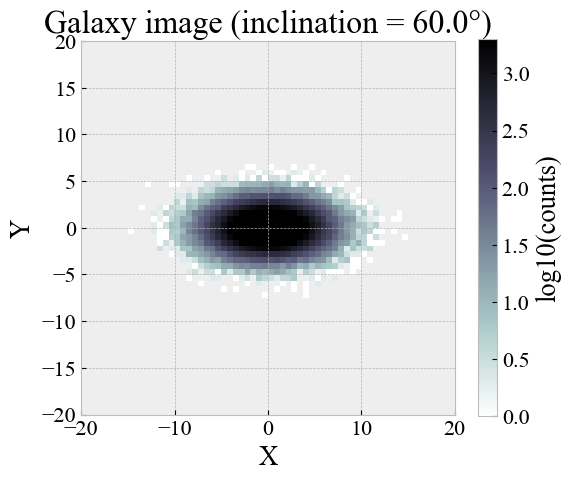

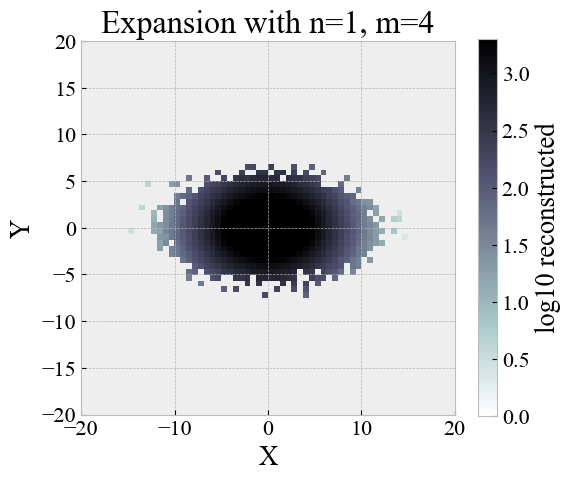

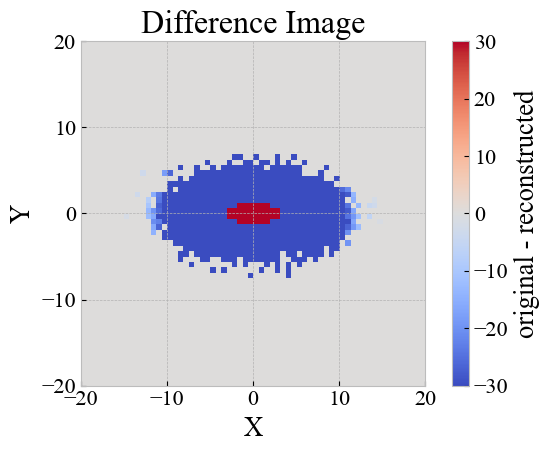

" \nplt.imshow(np.log10(E1.reconstruction), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)\nplt.colorbar(label='log10 counts')\nplt.xlabel('X')\nplt.ylabel('Y')\nplt.title(f'Expansion with n={n}, m={m}')\nplt.show()\n\nplt.figure()\n# why is there a 3%ish bias here?\nplt.imshow(D.img - 1.03*E1.reconstruction, origin='lower', cmap='coolwarm', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=-30.,vmax=30.)\nplt.colorbar(label='image - reconstruction difference')\nplt.xlabel('X')\nplt.ylabel('Y')\nplt.show() "

In [33]:

noise = 0.5
inclinationvalue = 60.  # degrees

D = DiscGalaxy(N=1000000, a=a)  # adjust N and a as needed
D.rotate_disc(inclinationvalue, 0, 0)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()
# --- Prepare safe log image ---
# Replace zero pixels with NaN to avoid log10(-inf) warnings
safe_img = np.where(D.img > 0, D.img, np.nan)
log_img = np.log10(safe_img)

# --- Plot the log-scaled image ---
plt.figure(figsize=(6, 5))
plt.imshow(log_img, origin='lower', cmap='bone_r',
           extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10(counts)')
plt.title(f"Galaxy image (inclination = {inclinationvalue}°)")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()


m=4
n=1
#Toggle this to see the expansion coefficients and how they change, goal: find the closest match to the image
E1 = D.make_pointexpansion(m,n,a*1.5,noisy=False)

# (re)construct an image from the expansion coefficients
E1.laguerre_reconstruction(D.r,D.p)

# Convert polar back to x, y (same grid as the image)
x = D.r * np.cos(D.p)
y = D.r * np.sin(D.p)
bins = [D.x_edges, D.y_edges]

recon_img, _, _ = np.histogram2d(x, y, bins=bins, weights=E1.reconstruction)
counts, _, _ = np.histogram2d(x, y, bins=bins)
recon_img /= np.maximum(counts, 1)
recon_img *= np.sum(img_orig) / np.sum(recon_img)
recon_img = recon_img.T
# Plot reconstructed image (gridded)
safe_recon = np.where(recon_img > 0, recon_img, np.nan)
log_recon = np.log10(safe_recon)

plt.figure(figsize=(6, 5))
plt.imshow(log_recon, origin='lower', cmap='bone_r',
           extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10 reconstructed')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Expansion with n={n}, m={m}')
plt.tight_layout()
plt.show()

# Optional: Difference plot
plt.figure()
plt.imshow(D.img - recon_img, origin='lower', cmap='coolwarm',
           extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
           vmin=-30., vmax=30.)
plt.colorbar(label='original - reconstructed')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Difference Image")
plt.tight_layout()
plt.show()
""" 
plt.imshow(np.log10(E1.reconstruction), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)
plt.colorbar(label='log10 counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Expansion with n={n}, m={m}')
plt.show()

plt.figure()
# why is there a 3%ish bias here?
plt.imshow(D.img - 1.03*E1.reconstruction, origin='lower', cmap='coolwarm', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=-30.,vmax=30.)
plt.colorbar(label='image - reconstruction difference')
plt.xlabel('X')
plt.ylabel('Y')
plt.show() """




## Automating the best coefficients

mmax: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]

Best match: mmax = 4, nmax = 4, NRMSE = 0.00423



/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_1665/538818807.py:58: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_orig), origin='lower', cmap='bone_r',


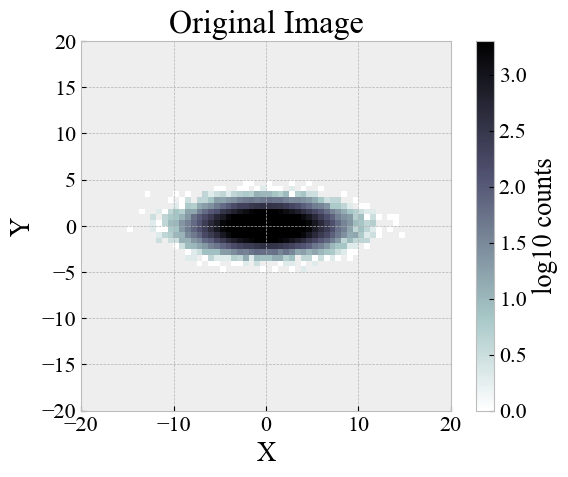

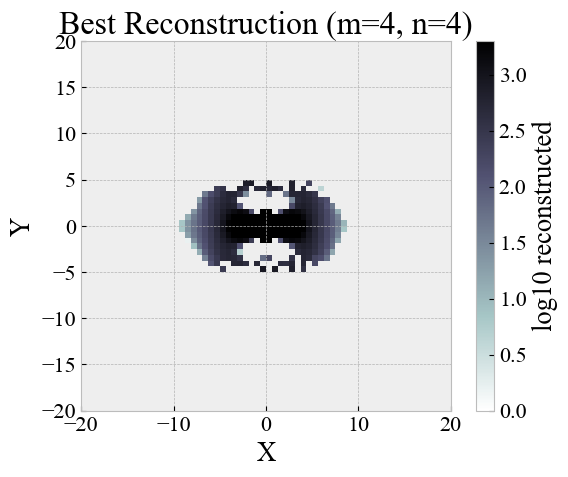

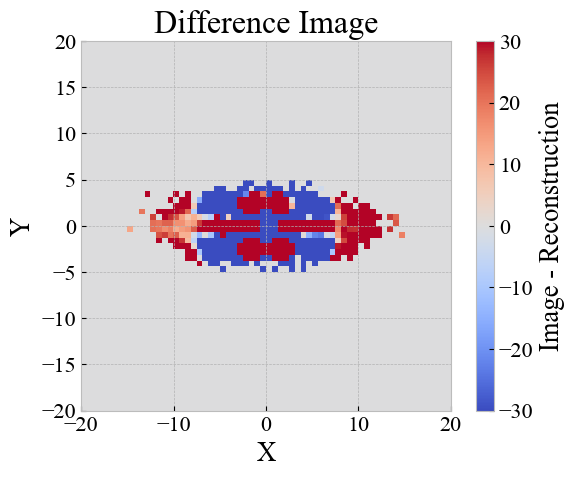

In [34]:

noise = 0.5
inclinationvalue = 70.

D = DiscGalaxy(N=N, a=a)
D.rotate_disc(inclinationvalue, 0, 0)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)

img_orig = D.img.copy()
x_edges, y_edges = D.x_edges, D.y_edges

#Finding the best expansion coefficients
# We will try different mmax and nmax values to find the best fit to the original
m_values = range(1, 5, 1) #vary m and n ranges to find the best fit
n_values = range(1, 5, 1)
errors = []
best_error = np.inf
best_config = None
best_E = None

for m in tqdm(m_values, desc="mmax"):
    for n in n_values:
        try:
            E = D.make_pointexpansion(m, n, a*1.5)
            E.laguerre_reconstruction(D.r, D.p)
            recon = E.reconstruction

            # Convert reconstruction to 2D histogram grid for fair comparison
            x = D.r * np.cos(D.p)
            y = D.r * np.sin(D.p)
            bins = [x_edges, y_edges]

            # Bin reconstructed values
            recon_img, _, _ = np.histogram2d(x, y, bins=bins, weights=E.reconstruction)
            counts, _, _ = np.histogram2d(x, y, bins=bins)
            recon_img /= np.maximum(counts, 1)
            recon_img *= np.sum(img_orig) / np.sum(recon_img)
            recon_img = recon_img.T
            # Now compare to original image
            mask = np.isfinite(img_orig) & np.isfinite(recon_img)
            nrmse = np.sqrt(np.mean((img_orig[mask] - recon_img[mask])**2)) / np.max(img_orig)


            errors.append((m, n, nrmse))

            if nrmse < best_error:
                best_error = nrmse
                best_config = (m, n)
                best_E = E
        except Exception as e:
            print(f"Failed at m={m}, n={n}: {e}")

# print and plot the best match
m_best, n_best = best_config
print(f"Best match: mmax = {m_best}, nmax = {n_best}, NRMSE = {best_error:.5f}")

#Original Image Plot
plt.figure()
plt.imshow(np.log10(img_orig), origin='lower', cmap='bone_r',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10 counts')
plt.title("Original Image")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot: Best Reconstruction 
plt.figure()
safe_recon = np.where(recon_img > 0, recon_img, np.nan)
log_recon = np.log10(safe_recon)

plt.imshow(log_recon, origin='lower', cmap='bone_r',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10 reconstructed')
plt.title(f"Best Reconstruction (m={m_best}, n={n_best})")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

difference = img_orig - recon_img

plt.figure()
plt.imshow(difference, origin='lower', cmap='coolwarm',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=-30, vmax=30)
plt.colorbar(label='Image - Reconstruction')
plt.title("Difference Image")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


## Realising coefficients and their dependence on inclination angle


<>:79: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\s'
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_1665/2650051317.py:79: SyntaxWarning: invalid escape sequence '\s'
  """ plt.plot(theta_deg, 0.1*np.sin(theta_rad), '--', label=r'$0.1\sin(\theta)$')


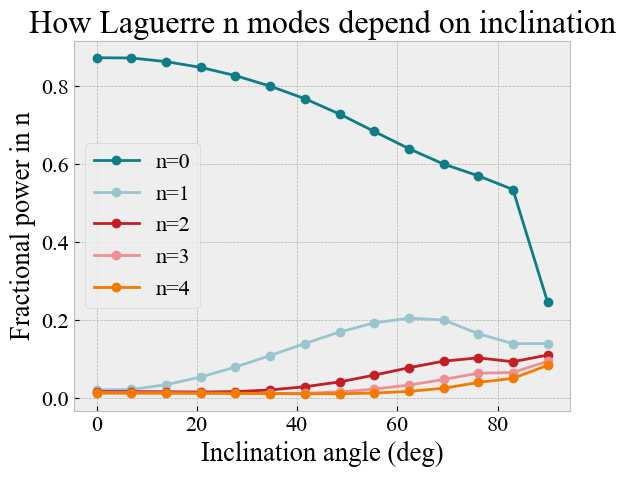

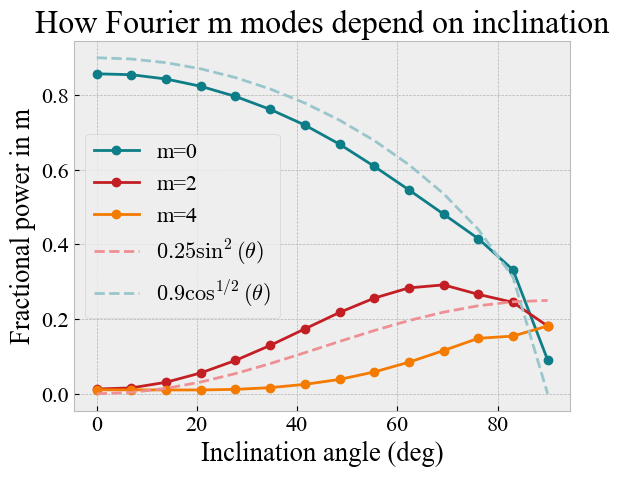

In [35]:
with h5py.File("example_galaxy.hdf5", "a") as f:
    group = f.require_group("f444w/00001_expansion")
    
    # Remove datasets if they exist
    for dname in ["coscoefs", "sincoefs"]:
        if dname in group:
            del group[dname]
    
    # Saving and grouing coefficients
    group.create_dataset("coscoefs", data=E.coscoefs)
    group.create_dataset("sincoefs", data=E.sincoefs)
    group.attrs["inclination_angle_deg"] = inclinationvalue


#Uncomment to print and check the coefficients
#print(E.coscoefs)
#print(E.sincoefs)

# Inclination angles to test, period of 90 degrees, 90 itself results in a fully inclined disc
inclinations = [0, 30, 60, 85]

# Prepare figure and loop through inclinations, storing coefficients results

for idx, inc in enumerate(inclinations):
    # Generate galaxy
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.)
    E = D.make_pointexpansion(mmax, nmax, a)
    
    # Compute magnitude of coefficients
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    
    # Sum over m to get total power per m
    m_power = np.sum(coef_mag, axis=1)
    
    
    n_power = np.sum(coef_mag, axis=0)

inclinations = np.linspace(0, 90, 14)  # Inclination angles from 0 to 85 degrees
colormap = ['teal','cornflowerblue','purple','midnightblue','olive','palevioletred','midnightblue']

colormap=['#0d7d87', '#99c6cc', '#c31e23', '#ee9093', '#f47a00']
# Store results
results = []

for inc in inclinations:
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.)
    E = D.make_pointexpansion(mmax, nmax, a)
    
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    m_power = np.sum(coef_mag, axis=1)
    n_power = np.sum(coef_mag, axis=0)
    total_n_power = np.sum(n_power)
    total_m_power = np.sum(m_power)
    fracn_power = n_power / total_n_power
    fracm_power = m_power / total_m_power
    
    results.append({
        "inclination": inc,
        "m_power": m_power,
        "n_power": n_power,
        "fracn_power": fracn_power,
        "fracm_power": fracm_power
    })

# Plot fractional power vs inclination for each n (Laguerre mode)
theta_deg = np.array([r["inclination"] for r in results])
theta_rad = np.radians(theta_deg)

for n in range(0,5,1):
    plt.plot(theta_deg,
             [r["fracn_power"][n] for r in results],
             marker='o', label=f"n={n}", color=colormap[n])

# Overplot trigonometric functions
""" plt.plot(theta_deg, 0.1*np.sin(theta_rad), '--', label=r'$0.1\sin(\theta)$')
plt.plot(theta_deg, 0.1*np.sin(theta_rad)**2, '--', label=r'$0.1\sin^2(\theta)$')
plt.plot(theta_deg, 0.65*np.cos(theta_rad)**2, '--', label=r'$0.65\cos^2(\theta)$')
plt.plot(theta_deg, 0.65*np.cos(theta_rad), '--', label=r'$0.65\cos(\theta)$')
 """
plt.xlabel("Inclination angle (deg)")
plt.ylabel("Fractional power in n")
plt.legend()
plt.title("How Laguerre n modes depend on inclination")
plt.show()

for m in range(0,5,2):
    plt.plot(theta_deg,
             [r["fracm_power"][m] for r in results],
             marker='o', label=f"m={m}", color=colormap[m])

# Overplot trigonometric functions
plt.plot(theta_deg, 0.25*np.sin(theta_rad)**2, '--', label=r'$0.25\sin^2(\theta)$', color='#ee9093')
plt.plot(theta_deg, 0.9*np.cos(theta_rad)**(1/2), '--', label=r'$0.9\cos^{1/2}(\theta)$', color='#99c6cc')
plt.xlabel("Inclination angle (deg)")
plt.ylabel("Fractional power in m")
plt.legend()
plt.title("How Fourier m modes depend on inclination")
plt.show()

a clear sinusoidal preiodic pattern but requires compressing in x axis, will proceed to find best fit later relative to m,n=0

## Comparing order ratios

Computing expansions: 100%|██████████| 30/30 [00:32<00:00,  1.10s/it]


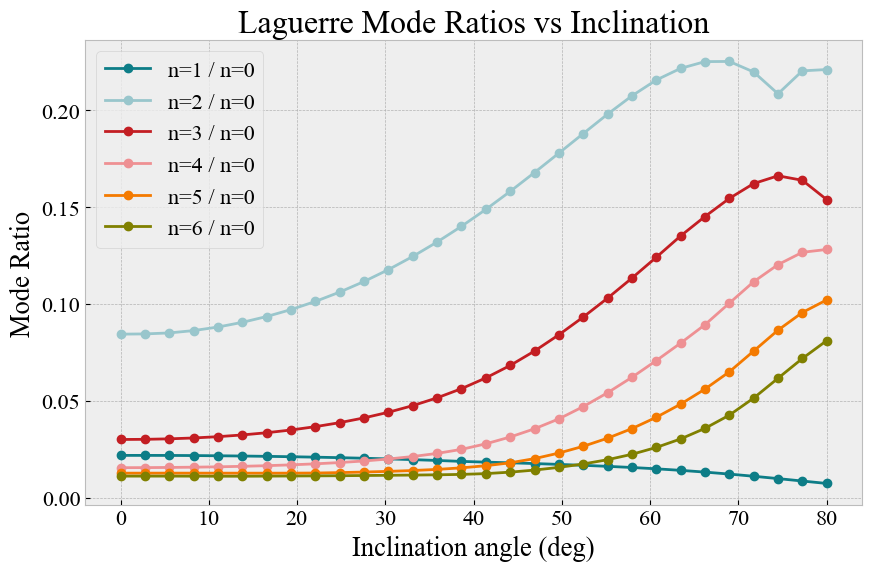

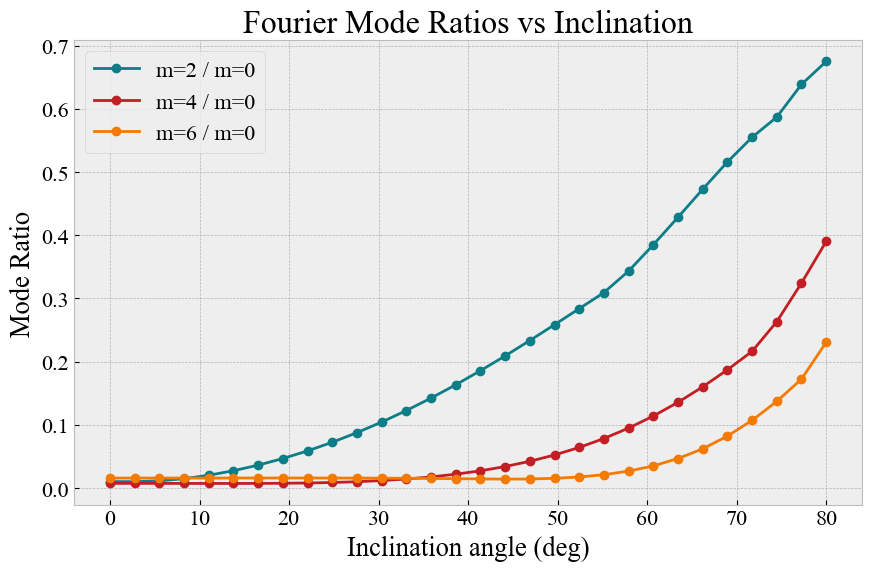

In [36]:

# Inclination angles to scan
inclinations = np.linspace(0, 80, 30)

# Store results
results = []

#Compute fractional power for each inclination
for inc in tqdm(inclinations, desc="Computing expansions"):
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    #D.generate_image(rmax=8.,nbins=512,noiselevel=0.5)

    E = D.make_pointexpansion(mmax, nmax, a*1.5)
    
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    m_power = np.sum(coef_mag, axis=1)
    n_power = np.sum(coef_mag, axis=0)
    total_n_power = np.sum(n_power)
    total_m_power = np.sum(m_power)
    fracm_power = m_power / total_m_power
    fracn_power = n_power / total_n_power
    
    results.append({
        "inclination": inc,
        "fracn_power": fracn_power,
        "fracm_power": fracm_power,
        "m_power": m_power,
        "n_power": n_power
    })

# Data for ratios
theta_deg = np.array([r["inclination"] for r in results])
Pn0 = np.array([r["fracn_power"][0] for r in results])
Pm1 = np.array([r["fracm_power"][1] for r in results])
Pn2 = np.array([r["fracn_power"][2] for r in results])
Pn3 = np.array([r["fracn_power"][3] for r in results])
Pn4 = np.array([r["fracn_power"][4] for r in results])
Pn5 = np.array([r["fracn_power"][5] for r in results])
Pn6 = np.array([r["fracn_power"][6] for r in results])

Rn1 = Pm1 / Pn0
Rn2 = Pn2 / Pn0
Rn3 = Pn3 / Pn0
Rn4 = Pn4 / Pn0
Rn5 = Pn5 / Pn0
Rn6 = Pn6 / Pn0

theta_rad = np.radians(theta_deg)

plt.figure(figsize=(9, 6))
colormap=['#0d7d87', '#99c6cc', '#c31e23', '#ee9093', '#f47a00']
plt.plot(theta_deg, Rn1, 'o-', label='n=1 / n=0', color='#0d7d87')
plt.plot(theta_deg, Rn2, 'o-', label='n=2 / n=0', color='#99c6cc')
plt.plot(theta_deg, Rn3, 'o-', label='n=3 / n=0', color='#c31e23')
plt.plot(theta_deg, Rn4, 'o-', label='n=4 / n=0', color='#ee9093')
plt.plot(theta_deg, Rn5, 'o-', label='n=5 / n=0', color='#f47a00')
plt.plot(theta_deg, Rn6, 'o-', label='n=6 / n=0', color='olive')

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Mode Ratio")
plt.title("Laguerre Mode Ratios vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

theta_deg = np.array([r["inclination"] for r in results])
Pm0 = np.array([r["fracm_power"][0] for r in results])
Pm2 = np.array([r["fracm_power"][2] for r in results])
Pm4 = np.array([r["fracm_power"][4] for r in results])
Pm6 = np.array([r["fracm_power"][6] for r in results])

Rm2 = Pm2 / Pm0
Rm4 = Pm4 / Pm0
Rm6 = Pm6 / Pm0

theta_rad = np.radians(theta_deg)

plt.figure(figsize=(9, 6))

plt.plot(theta_deg, Rm2, 'o-', label='m=2 / m=0', color='#0d7d87' )
plt.plot(theta_deg, Rm4, 'o-', label='m=4 / m=0', color='#c31e23')
plt.plot(theta_deg, Rm6, 'o-', label='m=6 / m=0', color='#f47a00')

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Mode Ratio")
plt.title("Fourier Mode Ratios vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


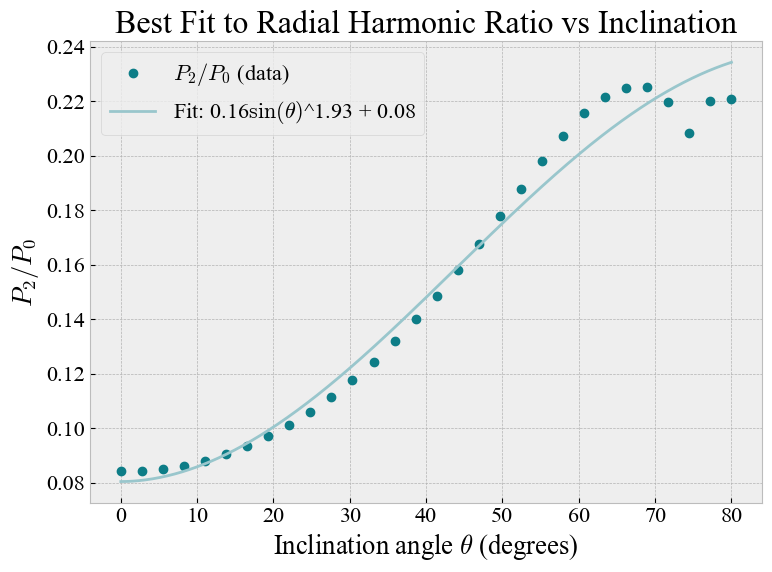

Best fit model:
  R(θ) = 0.158sin(theta)^1.928 + 0.081
RMSE = 0.00752


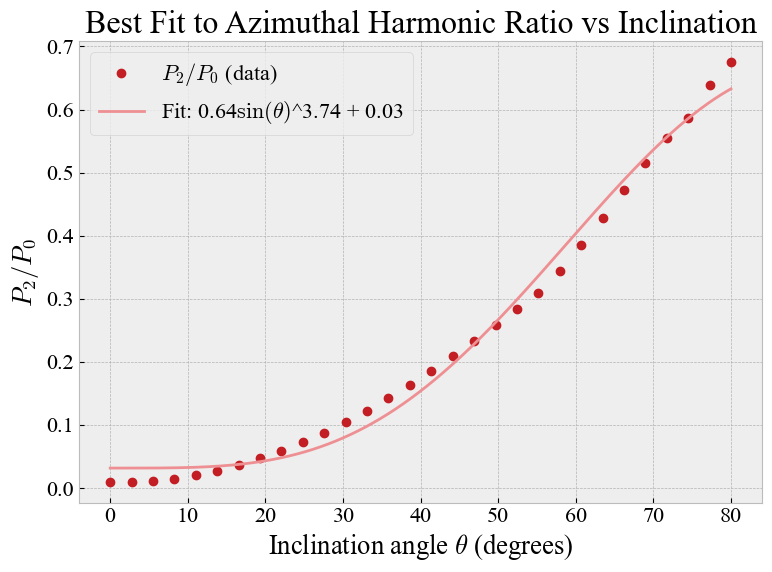

Best fit model:
  R(θ) = 0.637sin(theta)^3.736 + 0.032
RMSE = 0.01956


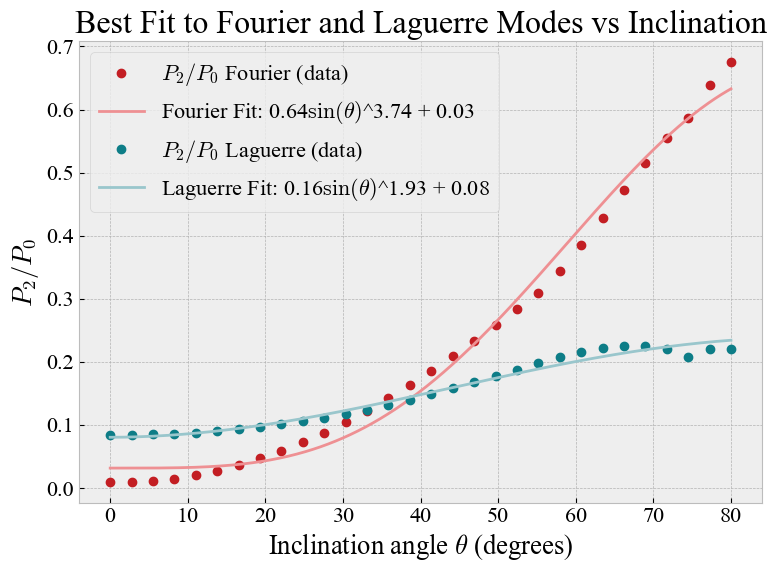

In [37]:
#Laguerre mode ratios vs inclination
#  Data 
theta_deg = np.array([r["inclination"] for r in results])
Pn0 = np.array([r["fracn_power"][0] for r in results])
Pn1 = np.array([r["fracn_power"][1] for r in results])
Pn2 = np.array([r["fracn_power"][2] for r in results])
Pn3 = np.array([r["fracn_power"][3] for r in results])
Pn4 = np.array([r["fracn_power"][4] for r in results])
Pn5 = np.array([r["fracn_power"][5] for r in results])
Pn6 = np.array([r["fracn_power"][6] for r in results])

Rn1 = Pn1 / Pn0
Rn2 = Pn2 / Pn0
Rn3 = Pn3 / Pn0
Rn4 = Pn4 / Pn0
Rn5 = Pn5 / Pn0
Rn6 = Pn6 / Pn0 # mode ratio
Rn4_2 = Pn4 / Pn2  # ratio of n=4 to n=2

#Fitting model
def model(theta_deg, A, B, C):
    theta_rad = np.radians(theta_deg)
    return A * np.sin(theta_rad)**B + C



Rnplot = Rn2
# Fit the model
popt, pcov = curve_fit(model, theta_deg, Rnplot, p0=[0.0, 1.0, 0.0])
An_fit, Bn_fit, Cn_fit = popt

# Evaluate the fit
theta_fit = np.linspace(0, 80, 500)
Rn_fit = model(theta_fit, *popt)

# Compute RMSE
Rn2_pred = model(theta_deg, *popt)
rmse = np.sqrt(np.mean((Rnplot - Rn2_pred)**2))


colormap=['#0d7d87', '#99c6cc', '#c31e23', '#ee9093', '#f47a00']
# Plot 
plt.figure(figsize=(8,6))
plt.plot(theta_deg, Rnplot, 'o', label=r'$P_2/P_0$ (data)', color='#0d7d87')
plt.plot(theta_fit, Rn_fit, '-', label=rf'Fit: {An_fit:.2f}$\sin(\theta)$^{Bn_fit:.2f} + {Cn_fit:.2f}', color='#99c6cc')
plt.xlabel(r"Inclination angle $\theta$ (degrees)")
plt.ylabel(r"$P_2 / P_0$")
plt.title("Best Fit to Radial Harmonic Ratio vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print formula and RMSE
print(f"Best fit model:\n  R(θ) = {An_fit:.3f}sin(theta)^{Bn_fit:.3f} + {Cn_fit:.3f}")
print(f"RMSE = {rmse:.5f}")

#Fourier mode ratios vs inclination
#  Data 
theta_deg = np.array([r["inclination"] for r in results])
Pm0 = np.array([r["fracm_power"][0] for r in results])
Pm2 = np.array([r["fracm_power"][2] for r in results])
Pm4 = np.array([r["fracm_power"][4] for r in results])
Pm6 = np.array([r["fracm_power"][6] for r in results])

Rm2 = Pm2 / Pm0
Rm4 = Pm4 / Pm0
Rm6 = Pm6 / Pm0 # mode ratio 
Rm6_4= Pm6 / Pm4  # ratio of m=6 to m=4
Rm4_2= Pm4 / Pm2  # ratio of m=4 to m=2

Rmplot=Rm2

#Fitting model
def model(theta_deg, A, B, C):
    theta_rad = np.radians(theta_deg)
    return A * np.sin(theta_rad)**B + C

# Fit the model
popt, pcov = curve_fit(model, theta_deg, Rmplot, p0=[1.0, 1.0, 0.01])
Am_fit, Bm_fit, Cm_fit = popt

# Evaluate the fit
theta_fit = np.linspace(0, 80, 500)
Rm_fit = model(theta_fit, *popt)

# Compute RMSE
Rm2_pred = model(theta_deg, *popt)
rmse = np.sqrt(np.mean((Rmplot - Rm2_pred)**2))

# Plot 
plt.figure(figsize=(8,6))
plt.plot(theta_deg, Rmplot, 'o', label=r'$P_2/P_0$ (data)', color='#c31e23')
plt.plot(theta_fit, Rm_fit, '-', label=rf'Fit: {Am_fit:.2f}$\sin(\theta)$^{Bm_fit:.2f} + {Cm_fit:.2f}', color='#ee9093')

plt.xlabel(r"Inclination angle $\theta$ (degrees)")
plt.ylabel(r"$P_2 / P_0$")
plt.title("Best Fit to Azimuthal Harmonic Ratio vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print formula and RMSE
print(f"Best fit model:\n  R(θ) = {Am_fit:.3f}sin(theta)^{Bm_fit:.3f} + {Cm_fit:.3f}")
print(f"RMSE = {rmse:.5f}") 


plt.figure(figsize=(8,6))
plt.plot(theta_deg, Rmplot, 'o', label=r'$P_2/P_0$ Fourier (data)', color='#c31e23')
plt.plot(theta_fit, Rm_fit, '-', label=rf'Fourier Fit: {Am_fit:.2f}$\sin(\theta)$^{Bm_fit:.2f} + {Cm_fit:.2f}', color='#ee9093')
plt.plot(theta_deg, Rnplot, 'o', label=r'$P_2/P_0$ Laguerre (data)', color='#0d7d87')
plt.plot(theta_fit, Rn_fit, '-', label=rf'Laguerre Fit: {An_fit:.2f}$\sin(\theta)$^{Bn_fit:.2f} + {Cn_fit:.2f}', color='#99c6cc')

plt.xlabel(r"Inclination angle $\theta$ (degrees)")
plt.ylabel(r"$P_2 / P_0$")
plt.title("Best Fit to Fourier and Laguerre Modes vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



dependence only on $\theta$, no additional factor in argument

## Comparing with real galaxy data and testing relations

In [38]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
""" 
np.load('expansion_data_10517-12701.npy', allow_pickle=True)[()]
np.load('expansion_data_7960-3701.npy', allow_pickle=True)[()]
np.load('expansion_data_12070-9102.npy', allow_pickle=True)[()]
np.load('expansion_data_7960-12701.npy', allow_pickle=True)[()]
np.load('expansion_data_7960-12703.npy', allow_pickle=True)[()]
np.load('expansion_data_7960-12704.npy', allow_pickle=True)[()]
np.load('expansion_data_7960-12705.npy', allow_pickle=True)[()]
np.load('expansion_data_8253-6102.npy', allow_pickle=True)[()]
np.load('expansion_data_8600-6104.npy', allow_pickle=True)[()]
np.load('expansion_data_8947-12704.npy', allow_pickle=True)[()]
np.load('expansion_data_8992-6101.npy', allow_pickle=True)[()]
np.load('expansion_data_8992-6103.npy', allow_pickle=True)[()]
np.load('expansion_data_8994-9101.npy', allow_pickle=True)[()]
np.load('expansion_data_9037-12701.npy', allow_pickle=True)[()]
np.load('expansion_data_9037-9102.npy', allow_pickle=True)[()]
"""
data1=np.load('flux_expansion_data_7960-3701.npy', allow_pickle=True)[()]
data2=np.load('flux_expansion_data_7960-12705.npy', allow_pickle=True)[()]
data3=np.load('flux_expansion_data_7960-3701.npy', allow_pickle=True)[()]
data4=np.load('flux_expansion_data_7960-3702.npy', allow_pickle=True)[()]
data5=np.load('flux_expansion_data_8600-6104.npy', allow_pickle=True)[()]



coscoefs1 = data1['coscoefs']
sincoefs1 = data1['sincoefs']    

P0 = np.sqrt(coscoefs1[0, 0,0]**2 + sincoefs1[0, 0,0]**2)
P2 = np.sqrt(coscoefs1[0, 0,2]**2 + sincoefs1[0, 0,2]**2)  
R2_0= P2 / P0  # Ratio of n=2 to n=0
print(R2_0)
true_inclination= data1['inclination']* 180/np.pi  # Convert from radians to degrees
print(true_inclination)


def estimate_inclination(R, A, B, C):
    if R < C or ((R - C) / A) ** B > 1:
        print("R is outside the valid inversion range.")
        estimated_incl = np.nan
    else:
        theta_rad = np.arcsin(((R - C) / A) ** B)
        estimated_incl = np.degrees(theta_rad)
        return estimated_incl

coscoefs2 = data2['coscoefs']
sincoefs2 = data2['sincoefs']
coscoefs3 = data3['coscoefs']
sincoefs3 = data3['sincoefs']
coscoefs4 = data4['coscoefs']
sincoefs4 = data4['sincoefs']   
coscoefs5 = data5['coscoefs']
sincoefs5 = data5['sincoefs']   

P0_2 = np.sqrt(coscoefs2[0, 0,0]**2 + sincoefs2[0, 0,0]**2)
P2_2 = np.sqrt(coscoefs2[0, 0,2]**2 + sincoefs2[0, 0,2]**2)
R2_0_2 = P2_2 / P0_2  # Ratio of n=2 to n=0
print(R2_0_2)
true_inclination_2 = data2['inclination'] * 180/np.pi  # Convert from radians to degrees
print(true_inclination_2)  
print("Estimated inclination for data2:", estimate_inclination(R2_0_2, Am_fit, Bm_fit, Cm_fit))


0.7464243732510334
[56.3444195]
0.3598180769899454
[34.82228924]
Estimated inclination for data2: 4.827325567946947
